# Pine Beetle Analysis 

## Introduction and Problem Background

In the forests of the western United States the mountain pine beetle Dendroctonus ponderosae (MPB) has traditionally been helpful in recycling weakened trees thus preserving good forest health. Although in recent years with climate change these insects have become more like pests causing widespread tree mortality. This has become a epidemic over the past several decades. 

Ecologists use annual aerial detection surveys (ADS) to analyze the extent of the damage done to the forests. The data for this analysis come from an ADS from the Colorado State Forest Service for the front range mountains in Colorado. The area of this survey covers from the southern Rocky Mountains in Colorado to southern Wyoming and the Black Hills of South Dakota. However, this analysis will focus on analyzing the data in the North Central Rocky Mountains in Colorado for its consistent pine tree cover. 

From the ADS we have covariate information that would be useful in a statistical analysis. The main motivation for this kind of analysis would be to build a model to get a predicted probability of new location of pine beetle infestation and to better understand which factors are contributing to said issue. The response variable in this analysis will be whether or not the region is infested with the pine beetle or not. The response is either yes or no which will be addressed shortly. Then there are multiple covariates such as high and low temperatures, slope and elevation of the area/mountain, precipitation, and region indicators.        

In [7]:
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import copy

#RUN for formatting:
#jupyter nbconvert --to html --template hidecode YourNotebook.ipynb

In [13]:
mbp = pd.read_csv('PineBeetle2.csv')
temp = copy.deepcopy(mbp)
#Make yes and no categorical 0/1
mbp['Infested'] = (mbp['Infested']=="Yes")*1

mbp['NC'] = mbp['NC'].astype('category')
mbp['NW'] = mbp['NW'].astype('category')
mbp['EC'] = mbp['EC'].astype('category')
mbp['WC'] = mbp['WC'].astype('category')
mbp['SE'] = mbp['SE'].astype('category')
mbp['SC'] = mbp['SC'].astype('category')
mbp['SW'] = mbp['SW'].astype('category')

Below are a couple plots to explore our data a little closer. Isolating infested and precip we can see that as precipitation rises the chances of an area being infested increases. And for infested and August_max	we can see that as August_max	increases the chances of an area being infested decreases having a negative association. After doing this kind of data exploration we see that the response is an indicator variable which means it says only if a location is infested or not. This will determine what kind of analysis we will need to do in order to create a model and make predictions. For this kind of analysis we will want to use a logistic regression model as it will model the behavior of our response variable as compared to a multiple linear regression model which is better for modeling response variables that are in the set of reals or other types of models such as Poisson regression which models the response as a Poisson distribution.  

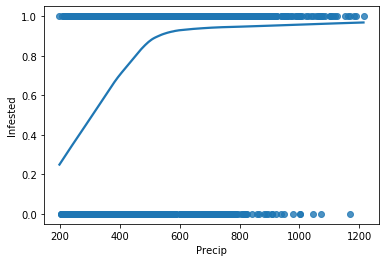

In [27]:
sns.regplot(x="Precip", y="Infested", data=mbp, lowess=True)

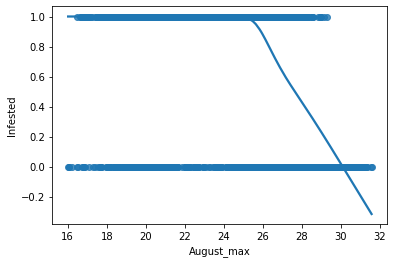

In [33]:
sns.regplot(x="August_max", y="Infested", data=mbp, lowess=True)

Since the response variable (infested or not infested) is binary, the statistical method that would be suitable for this analysis would be a logistic regression method. The model for this this logistic regression method will be discussed below.  

##  Statistical Modeling

### Variable Selection

The main goal of variable selection is to choose the appropriate variables to add to the model. For this model I used best subset selection procedure which considers all possible combinations of variables. Since we had a reasonable amount of variables (not computationally intensive) this method seemed ideal. I also based my variable selection procedure on the BIC. I chose this procedure as it seems to optimize for both prediction and inference. Below is the mathematical model which includes the variables that were selected namely, January, August_max, Precip, NC, and SE regions.

In [4]:
#Variable and Model Selection
from rpy2.robjects.packages import importr 
from rpy2.robjects import pandas2ri
pandas2ri.activate() # this activates an R session within python
base_r = importr('base')
bestglm = importr('bestglm')
stats = importr('stats')

select = bestglm.bestglm(mbp, family=stats.binomial, IC="BIC", method="exhaustive")
#print(base_r.summary(select.rx2('BestModel')))

In [3]:
#Fitting a model
log_reg = smf.glm(formula='Infested~January+August_max+Precip+NC+SE', data=mbp,
                   family=sm.families.Binomial()).fit()
#log_reg.summary()

## Statistical Model

 **Logistic Regression Model:** $log(\frac{p_i}{1-p_i}) = \beta_0 + \beta_1 (January_i) + \beta_2 (AugustMax_i) + \beta_3 (Precip_i) + \beta_4 (NCYes_i) + \beta_5 (SEYes_i)$
 
$y_i \stackrel{iid}{\sim} Bern(p_i)$ Since our response is either yes or no we need a proper distribution to model this. 

$\beta_0$ - The intercept. On average this is what we would expect the $log(\frac{p_i}{1-p_i})$ to be if all other variables were zero. 

$\beta_3 (Precip_i)$ - The 3rd explanatory variable Precip can be interpreted as: holding all else constant if precipitation increases by 1 unit then a new area is (100 x (exp{$\beta_1$} - 1)% more likely to be infested. Other covariates can be interpreted in the same manner.

$\beta_5 (SEYes_i)$ - For a categorical variable such as SEYes we can interpret this as an area that is located in the SE region, holding all else constant, on average, is (100 x (exp{$\beta_5$} - 1)% less likely to be infested than an area that is in another area. 

### Assumptions 

For this model we are assuming that the data are independent and linear in log-odds. For independence all we need to do is think about how one area might influence another. Since different areas are normally selected randomly we can assume that one area will not influence another. It is reasonable to say that one area will not affect another differently. As for checking linear in log-odds we just need to plot a scatterplot with smooth curves and make sure the curve is monotone in probability. The plots below seem to indicate this assumption is met. 

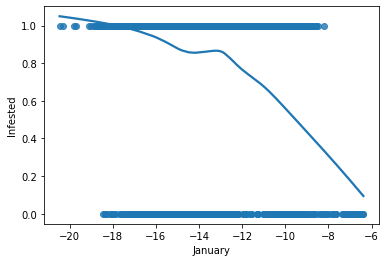

In [18]:
sns.regplot(x="January", y="Infested", data=mbp, lowess=True)

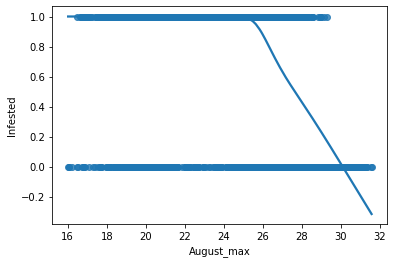

In [7]:
sns.regplot(x="August_max", y="Infested", data=mbp, lowess=True)

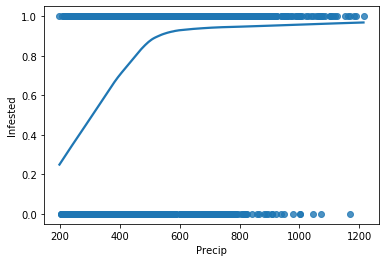

In [8]:
sns.regplot(x="Precip", y="Infested", data=mbp, lowess=True)

## Results

The results of the logistic regression model can be found in the table below. The covariate is listed on the left, the estimates next, then the 95% confidence interval for each effect. We can interpret the interval for Precip as, we are 95% confident that as precipitation increases by 1 unit the likelihood of a new area being infested increases between (.2, .4)%. For negatively associated properties we can interpret the interval as a decrease in likelihood. For example, we are 95% confident that as the average January minimum temperature by 1 unit degrees C decreases the likelihood of a new area being infested by between (9.52, 17.55)% 

| Covariate | Coefficient Estimate | [.025] | [.0975] | $e^{Estimate}$ | $e^{2.5\%}$ | $e^{97.5\%}$
| --- | --- | --- | --- | --- | --- | --- |
| Intercept | -0.157 | -1.884 | 1.569 | --| --| --|
| NC[T.Yes] | -1.2183 | -1.512 | -0.924 |70.43 | 77.95 | 60.3 |
| SE[T.Yes]	 | -0.9191 | -1.218 | -0.620 | 60.10 | 70.40 | 46.20 |
| January | -0.1466 | -0.193 | -0.100 | 13.64 | 17.55 | 9.52 |
| August_max | -0.0851 | -0.132 | -0.038 | 8.16 | 12.37 | 3.73 |
| Precip | 0.0029 | 0.002 | 0.004 | .29 | .20 | .40 |

### Threshold for classification

Below I went through a process of finding a threshold classification (.4949) that minimizes the misclassification rate. In other words, this is the threshold that  minimizes misclassifying an area as infested when it is not. The plot below shows the value .4949 that was calculated. The cutoff is on the x axis and the misclassification is on the y. From the plot .4949 does seem to be the minimized value. This is the value I will use for the cutoff for the model.   

In [10]:
#predicted probabilities, which are just our "fitted values"
pred_probs = log_reg.fittedvalues

#create a sequence that contains 100 potential thresholds between 0 and 1
thresh = np.linspace(0,1,num=100)

#create an empty vector that is the same length as thresh to store the misclassification rate for each threshold
misclass = np.repeat(np.NaN,repeats=thresh.size)

#figure out which threshold minimizes the misclassification
for i in range(thresh.size): 
    my_classification = pred_probs>thresh[i] 
    misclass[i] = np.mean(my_classification!=mbp['Infested'])
    
#Find threshold which minimizes miclassification
thresh[np.argmin(misclass)]

0.494949494949495

Text(0, 0.5, 'Misclassification')

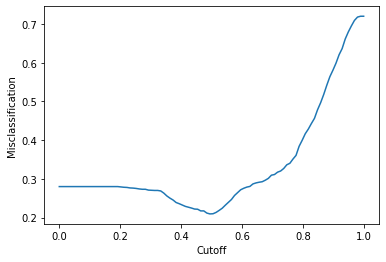

In [11]:
plt.plot(thresh, misclass)
plt.xlabel("Cutoff")
plt.ylabel("Misclassification")

### Model Fit

To help assess the fit of the model I have built a confusion matrix for all the data below using the classification threshold that was just found. 

| --- | Predicted No | Predicted Yes |
| --- | --- | --- |
| True No | 245 | 402 | 
| True Yes | 82 | 1581 |

Pseudo-$R^2$ tells us the percent of variation in $log(\frac{p}{1-p})$ is explained by modeling. This value is 0.1410 or 14.1% of variation in $log(\frac{p}{1-p})$ is explained by modeling. 

AUC (area under the ROC curve) tells us how well we classify across all thresholds. The plot of the ROC can be found in the plot below. We got an AUC of 0.7549 which says we the model classifies a area correctly about 75% of the time. Meaning if we picked a new area/location we would correctly identify if it was infested 75% of the time.  

0.7549195556344515

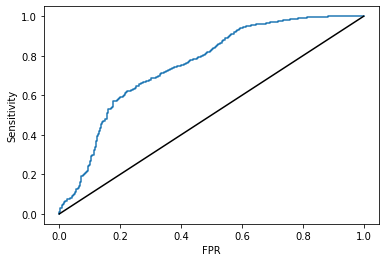

In [5]:
#AUC curve
fpr,sens,th = roc_curve(mbp['Infested'],log_reg.predict())

plt.plot(fpr,sens) #plots the ROC curve
plt.plot([0,1],[0,1],'k') #adds a 1-1 line for reference
plt.xlabel('FPR') #adds an x label.
plt.ylabel('Sensitivity') #adds an y label.

#to know how well we classify under all thresholds, we can report the area under the ROC curve (AUC).
auc(fpr,sens)

### Results
Sensitivity: The percent of True Positives is 86.6% for all the data. This is where the model predicted positive (infested) and it is true. 

Specificity: The percent of True Negatives is 16.9% for all the data. This is where the model predicted negative (not infested) and it is true. 

Positive Predictive Value: The percent of correctly predicting positive for infestation in a new area (Yes's) is 79.7% for all the data.

Negative Predictive Value: The percent of correctly predicting negative for infestation in a new area (No's) is 25.1% for all the data.

In [12]:
fn=245
fp=402
tn=82
tp=1581

sens = tp/(tp+fn)
spec = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)

In [13]:
#Confusion Matrix
confusion_matrix(mbp['Infested'],thresh[np.argmin(misclass)]<pred_probs)

array([[ 245,  402],
       [  82, 1581]], dtype=int64)

In [14]:
#psedo-R^2
1-(log_reg.deviance/log_reg.null_deviance)

0.1410423747895082

### Assessing Predictive Ability In the Model

Below I ran a cross-validation study using the threshold found earlier to classify the test areas. This procedure will show how well this model does a predicting new locations where pine beetle infestations will occur. The results from this study are as follows with an included explanation:

Sensitivity: The percent of True Positives is 92% for the cross-validated studies. 

Specificity: The percent of True Negatives is 42.4% for the cross-validated studies.

Positive Predictive Value: The percent of correctly predicting positive for infestation in a new area (Yes's) is 80.4% for the cross-validated studies.

Negative Predictive Value: The percent of correctly predicting negative for infestation in a new area (No's) is 67.5% for the cross-validated studies.

In [25]:
#Cross Validation

## Choose number of CV studies to run in a loop & test set size
n_cv = 500
n_test = int(np.round(.1*mbp.shape[0]))
## Set my threshold for classifying
cutoff = .4949
## Initialize matrices to hold CV results
sens = np.repeat(np.NaN,n_cv)
spec = np.repeat(np.NaN,n_cv)
ppv = np.repeat(np.NaN,n_cv)
npv = np.repeat(np.NaN,n_cv)
auc_value = np.repeat(np.NaN,n_cv)
n = len(mbp['Infested']) 

## Begin for loop
for cv in range(n_cv):
    ## Separate into test and training sets
    # Choose which obs. to put in test set
    testObs = np.random.choice(n, n_test)
    
    # Split data into test and training sets
    test_set = mbp.iloc[testObs,:]
    trainSet = mbp.drop(testObs)
    
    ## Fit best model to training set
    train_model = smf.glm(formula='Infested~January+August_max+Precip+NC+SE', data=mbp,
                          family=sm.families.Binomial()).fit()
        
    ## Use fitted model to predict test set
    pred_probs = train_model.predict(test_set)
    
    ## Classify according to threshold
    test_class = pred_probs > cutoff
    
    ## Create a confusion matrix
    conf_mat = confusion_matrix(test_set['Infested'],test_class)
    
    ## Pull of sensitivity, specificity, PPV and NPV
    ## using bracket notation
    tn,fp,fn,tp = conf_mat.ravel()
    sens[cv] = tp/(tp+fn)
    spec[cv] = tn/(tn+fp)
    ppv[cv] = tp/(tp+fp)
    npv[cv] = tn/(tn+fn)
    
    ## Calculate AUC
    fpr,tpr,th = roc_curve(test_set['Infested'],pred_probs)
    auc_value[cv] = auc(fpr,tpr)
## End for loop

#Sensitivity 
print("Sensitivity: {}".format(np.mean(sens)))

#Specificity 
print("Specificity: {}".format(np.mean(spec)))

#Positive Predictive Value 
print("Positive Predictive Value: {}".format(np.mean(ppv)))

#Negative Predictive Value 
print("Negative Predictive Value: {}".format(np.mean(npv)))

#AUC 
print("AUC: {}".format(np.mean(auc_value)))

Sensitivity: 0.9517516126800908
Specificity: 0.37347533168007524
Positive Predictive Value: 0.7958051012230735
Negative Predictive Value: 0.7518982115081841
AUC: 0.7557838908090919


## Making a prediction

For this particular prediction I choose three years from the 10 forecasts for the next 10 years. I choose 2020, 2024, and 2027. The set data were a South East region with a slope of 18.07 and elevation of 1901.95. Each forecast contained  August temperatures, minimum January temperatures and precipitation. These were the information that I entered into the model with the exception of slope and elevation since these effects were not included in the model. 

For each of these years the predicted probability was found to be above the cutoff value. Thus, assuming our model is predicting well, we could expect that this region will become infested in the next 10 years. This seems reasonable since the Positive Predictive Value found in the cross-validation study was 80%. This says the model correctly predicts positive for infestation in a new area 80% percent of the time. Although this is not a perfect number it is a reasonably high percentage. Give the high percentage it would not be a wasted effort to focus on an area that has been classified as being infested as most of the time this prediction would be correct. 

In [22]:
#Predictions:
dframe = pd.DataFrame(dict(NC=["No", "No", "No"], SE=["Yes", "Yes", "Yes"], 
                           January=[-17.27, -15.75, -12.44], 
                           August_max=[ 16.74, 16.85, 16.96], 
                           Precip=[ 677.63,  805.90, 801.22]))

print("Prediction: {}".format(log_reg.predict(dframe)))
log_reg.predict(dframe) > .4949 #Cutoff

Prediction: 0    0.878460
1    0.892270
2    0.832852
dtype: float64


0    True
1    True
2    True
dtype: bool

## Conclusions

From this analysis we have determined the main effects that are import to consider when determining if an area is infested. We have also created a model for making predictions about these locations. What could be concluded within this analysis is that areas with low January temperatures and are located in the regions NC and SE are much less likely to be infested. In contrast areas with higher precipitation and higher temperatures for January tend to have a higher probability of being infested. 

Future goals ecologists should consider is focusing on areas other than the regions of NC and SE and regions that have high precipitation and a lower January minimum temperature. Perhaps the study could be continued by understanding why warmer areas tend to be more infested and if there are ways of mitigating this some how. 